In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model.layers import NestedDropout
from model.cmpnts import MLP, SNMLP
from model.layers import SNLinearCombo
from toy_experiment import DynamicPruningAE, generate_configs
from torch.linalg import svd

# 2D
## 1D Manifold

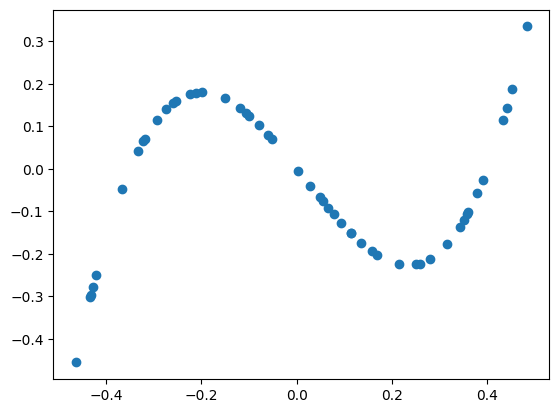

In [42]:
X, _ = torch.sort(torch.rand(50))
X = X - 0.5
# Y = X + 5 * X ** 3 
Y = 10 * (X-0.4) * X * (X+0.35)

plt.scatter(X.numpy(), Y.numpy())
plt.show()

In [52]:
configs = generate_configs(2, [32]*4, 'prune')
configs['beta'] = 0.9
configs['z_t'] = 5e-3
configs['r_t'] = 1e-6
ae = DynamicPruningAE(configs, MLP, SNMLP, torch.optim.Adam, [1., 1e-4])

data = torch.stack([X, Y], dim=-1)

In [53]:
from torch.utils.data import DataLoader
dataloader = DataLoader(data, batch_size=50, shuffle=True)

In [54]:
ae.fit(dataloader, 5000)

Training prune: 100%|██████████████████████████████| 5000/5000 [00:45<00:00, 108.79it/s, rec=6.48e-7, spar=0.991] 


In [55]:
ae._zstd_

tensor([1.0002e+00, 5.6052e-45])

In [56]:
ae._p

tensor([False,  True])

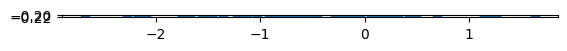

In [57]:
ae.eval()

z = ae.encode(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [58]:
z.max(0)[0] - z.min(0)[0]

tensor([4.3185, 0.0000], grad_fn=<SubBackward0>)

In [59]:
z.T.cov()

tensor([[ 9.8054e-01, -7.2504e-16],
        [-7.2504e-16,  2.2658e-16]], grad_fn=<SqueezeBackward0>)

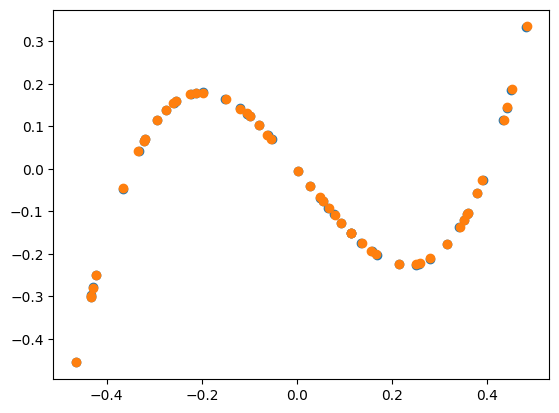

In [60]:
rec = ae.decode(z).detach().numpy()
plt.scatter(X.numpy(), Y.numpy())
plt.scatter(rec[:, 0], rec[:, 1])

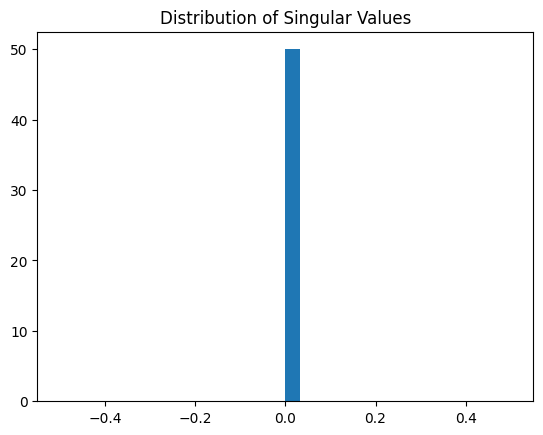

In [61]:
def f(x):
    return ae.encode(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[1]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()